In [1]:
from os import path

# Third-party
import astropy.coordinates as coord
from astropy.table import Table, vstack
from astropy.io import fits, ascii
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.optimize import minimize
from pyia import GaiaData

import gala.coordinates as gc
import gala.dynamics as gd
from gala.dynamics import mockstream
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic
from gala.mpl_style import center_emph

Load the "data":

In [2]:
ana_data = Table.read('../data/track.fits')
ana_data.colnames

['phi1',
 'n',
 'n_back',
 'density',
 'phi2',
 'w',
 'pm_phi1_cosphi2',
 'pm_phi1_cosphi2_error',
 'pm_phi2',
 'pm_phi2_error']

In [3]:
# Koposov et al. 
kop_pm = ascii.read("""phi1 pm_phi1 pm_phi2 err
-55.00 -13.60 -5.70 1.30
-45.00 -13.10 -3.30 0.70
-35.00 -12.20 -3.10 1.00
-25.00 -12.60 -2.70 1.40
-15.00 -10.80 -2.80 1.00""")

kop_phi2 = ascii.read("""phi1 phi2 err
-60.00 -0.64 0.15
-56.00 -0.89 0.27
-54.00 -0.45 0.15
-48.00 -0.08 0.13
-44.00 0.01 0.14
-40.00 -0.00 0.09
-36.00 0.04 0.10
-34.00 0.06 0.13
-32.00 0.04 0.06
-30.00 0.08 0.10
-28.00 0.03 0.12
-24.00 0.06 0.05
-22.00 0.06 0.13
-18.00 -0.05 0.11
-12.00 -0.29 0.16
-2.00 -0.87 0.07""")

kop_dist = ascii.read("""phi1 dist err
-55.00 7.20 0.30
-45.00 7.59 0.40
-35.00 7.83 0.30
-25.00 8.69 0.40
-15.00 8.91 0.40
0.00 9.86 0.50""")

kop_vr = ascii.read("""phi1 phi2 vr err
-45.23 -0.04 28.8 6.9
-43.17 -0.09 29.3 10.2
-39.54 -0.07 2.9  8.7
-39.25 -0.22 -5.2 6.5
-37.95 0.00 1.1   5.6
-37.96 -0.00 -11.7 11.2
-35.49 -0.05 -50.4 5.2
-35.27 -0.02 -30.9 12.8
-34.92 -0.15 -35.3 7.5
-34.74 -0.08 -30.9 9.2
-33.74 -0.18 -74.3 9.8
-32.90 -0.15 -71.5 9.6
-32.25 -0.17 -71.5 9.2
-29.95 -0.00 -92.7 8.7
-26.61 -0.11 -114.2 7.3
-25.45 -0.14 -67.8 7.1
-24.86 0.01 -111.2 17.8
-21.21 -0.02 -144.4 10.5
-14.47 -0.15 -179.0 10.0
-13.73 -0.28 -191.4 7.5
-13.02 -0.21 -162.9 9.6
-12.68 -0.26 -217.2 10.7
-12.55 -0.23 -172.2 6.6""")

In [4]:
dt = 0.5 * u.Myr
n_steps = 200

_phi2_sigma = 0.2 # deg
_dist_sigma = 0.1 # kpc
_vr_sigma = 1 # km/s

def ln_likelihood(p, phi1_0, data, ham, gc_frame):
    # initial conditions at phi1_0
    phi2, d, pm1, pm2, vr = p
    
    c = gc.GD1(phi1=phi1_0, phi2=phi2*u.deg, distance=d*u.kpc, 
               pm_phi1_cosphi2=pm1*u.mas/u.yr,
               pm_phi2=pm2*u.mas/u.yr,
               radial_velocity=vr*u.km/u.s)
    w0 = gd.PhaseSpacePosition(c.transform_to(gc_frame).cartesian)
    
    orbit = ham.integrate_orbit(w0, dt=dt, n_steps=n_steps)
    model_gd1 = orbit.to_coord_frame(gc.GD1, galactocentric_frame=gc_frame)
    
    model_x = model_gd1.phi1.wrap_at(180*u.deg).degree
    if model_x[-1] < -180:
        return -np.inf
    
    model_phi2 = model_gd1.phi2.degree
    model_dist = model_gd1.distance.to(u.kpc).value
    model_pm1 = model_gd1.pm_phi1_cosphi2.to(u.mas/u.yr).value
    model_pm2 = model_gd1.pm_phi2.to(u.mas/u.yr).value
    model_vr = model_gd1.radial_velocity.to(u.km/u.s).value
    
    # plt.errorbar(data['phi2'][0], data['phi2'][1], marker='o', linestyle='none')
#     plt.errorbar(data['pm2'][0], data['pm2'][1], marker='o', linestyle='none')
#     plt.plot(model_x, model_pm2)
#     return
    
    ix = np.argsort(model_x)
    model_x = model_x[ix]
    
    # define interpolating functions
    order = 3
    bbox = [-180, 180]
    
    chi2 = 0
    
    phi2_interp = InterpolatedUnivariateSpline(model_x, model_phi2[ix], 
                                               k=order, bbox=bbox)
    dist_interp = InterpolatedUnivariateSpline(model_x, model_dist[ix], 
                                               k=order, bbox=bbox)
    pm1_interp = InterpolatedUnivariateSpline(model_x, model_pm1[ix], 
                                              k=order, bbox=bbox)
    pm2_interp = InterpolatedUnivariateSpline(model_x, model_pm2[ix], 
                                              k=order, bbox=bbox)
    vr_interp = InterpolatedUnivariateSpline(model_x, model_vr[ix], 
                                             k=order, bbox=bbox)
    
    phi2_sigma = np.sqrt(_phi2_sigma**2 + data['phi2'][2]**2)
    chi2 += np.sum(-(phi2_interp(data['phi2'][0]) - data['phi2'][1])**2 / phi2_sigma**2 - 2*np.log(phi2_sigma))
    
    dist_sigma = np.sqrt(_dist_sigma**2 + data['dist'][2]**2)
    chi2 += np.sum(-(dist_interp(data['dist'][0]) - data['dist'][1])**2 / dist_sigma**2 - 2*np.log(dist_sigma))
    
    pm1_sigma = data['pm1'][2]
    chi2 += np.sum(-(pm1_interp(data['pm1'][0]) - data['pm1'][1])**2 / pm1_sigma**2 - 2*np.log(pm1_sigma))
    
    pm2_sigma = data['pm2'][2]
    chi2 += np.sum(-(pm2_interp(data['pm2'][0]) - data['pm2'][1])**2 / pm2_sigma**2 - 2*np.log(pm2_sigma))
    
    vr_sigma = np.sqrt(data['vr'][2]**2 + _vr_sigma**2)
    chi2 += np.sum(-(vr_interp(data['vr'][0]) - data['vr'][1])**2 / vr_sigma**2 - 2*np.log(vr_sigma))

    return chi2

In [5]:
data = dict()

# Koposov data:
# data['phi2'] = (kop_phi2['phi1'], kop_phi2['phi2'], kop_phi2['err'])
# data['dist'] = (kop_dist['phi1'], kop_dist['dist'], kop_dist['err'])
# data['pm1'] = (kop_pm['phi1'], kop_pm['pm_phi1'], kop_pm['err'])
# data['pm2'] = (kop_pm['phi1'], kop_pm['pm_phi2'], kop_pm['err'])
# data['vr'] = (kop_vr['phi1'], kop_vr['vr'], kop_vr['err'])

# Ana's track:
data['phi2'] = (ana_data['phi1'], ana_data['phi2'], ana_data['w'])
data['dist'] = (kop_dist['phi1'], kop_dist['dist'], kop_dist['err'])
data['pm1'] = (ana_data['phi1'], ana_data['pm_phi1_cosphi2'], ana_data['pm_phi1_cosphi2_error'])
data['pm2'] = (ana_data['phi1'], ana_data['pm_phi2'], ana_data['pm_phi2_error'])
data['vr'] = (kop_vr['phi1'], kop_vr['vr'], kop_vr['err'])

{'disk': OrderedDict([('m', <Quantity 5.5e+10 solMass>), ('a', <Quantity 3. kpc>), ('b', <Quantity 0.28 kpc>)]), 'bulge': OrderedDict([('m', <Quantity 4.e+09 solMass>), ('c', <Quantity 1. kpc>)]), 'nucleus': OrderedDict([('m', <Quantity 0. solMass>), ('c', <Quantity 0.07 kpc>)]), 'halo': OrderedDict([('m', <Quantity 7.e+11 solMass>), ('r_s', <Quantity 15.62 kpc>), ('c', <Quantity 0.95>)])}


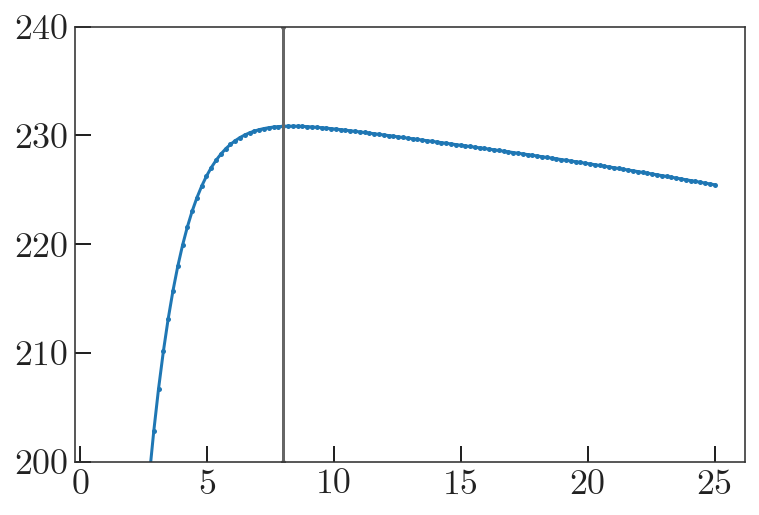

In [6]:
# ham = gp.Hamiltonian(gp.LogarithmicPotential(v_c=225*u.km/u.s, r_h=0*u.kpc, q1=1, q2=1, q3=0.89, 
#                                              units=galactic))

ham = gp.Hamiltonian(gp.MilkyWayPotential(nucleus=dict(m=0), 
                                          halo=dict(c=0.95, m=7E11),
                                          bulge=dict(m=4E9),
                                          disk=dict(m=5.5e10)))
print(ham.potential.parameters)

xyz = np.zeros((3, 128))
xyz[0] = np.linspace(1, 25, 128)

plt.plot(xyz[0], ham.potential.circular_velocity(xyz))
plt.ylim(200, 240)
plt.axvline(8)

In [7]:
gc_frame = coord.Galactocentric(galcen_distance=8*u.kpc, z_sun=0*u.pc)
phi1_0 = 20. * u.deg

p0 = (-3., 12., -5.5, -1.5, -340.)

In [8]:
res = minimize(lambda *x: -ln_likelihood(*x), x0=p0, args=(phi1_0, data, ham, gc_frame))

In [9]:
res

      fun: 65.63393477102522
 hess_inv: array([[ 1.24320655e-04, -9.73014937e-05, -1.76954924e-04,
        -1.60887411e-05,  4.88767529e-05],
       [-9.73014937e-05,  1.11636177e-04,  1.94782953e-04,
         1.94626284e-05, -5.79057541e-05],
       [-1.76954924e-04,  1.94782953e-04,  3.41602291e-04,
         3.27747333e-05, -1.00628370e-04],
       [-1.60887411e-05,  1.94626284e-05,  3.27747333e-05,
         8.55232664e-06, -1.17503453e-05],
       [ 4.88767529e-05, -5.79057541e-05, -1.00628370e-04,
        -1.17503453e-05,  3.14791613e-05]])
      jac: array([1.31607056e-04, 2.86102295e-05, 6.48498535e-05, 1.75476074e-04,
       7.62939453e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 1265
      nit: 25
     njev: 178
   status: 2
  success: False
        x: array([  -3.47508128,   12.26167861,   -5.70045271,   -1.44728289,
       -326.96300355])

In [10]:
res.x

array([  -3.47508128,   12.26167861,   -5.70045271,   -1.44728289,
       -326.96300355])

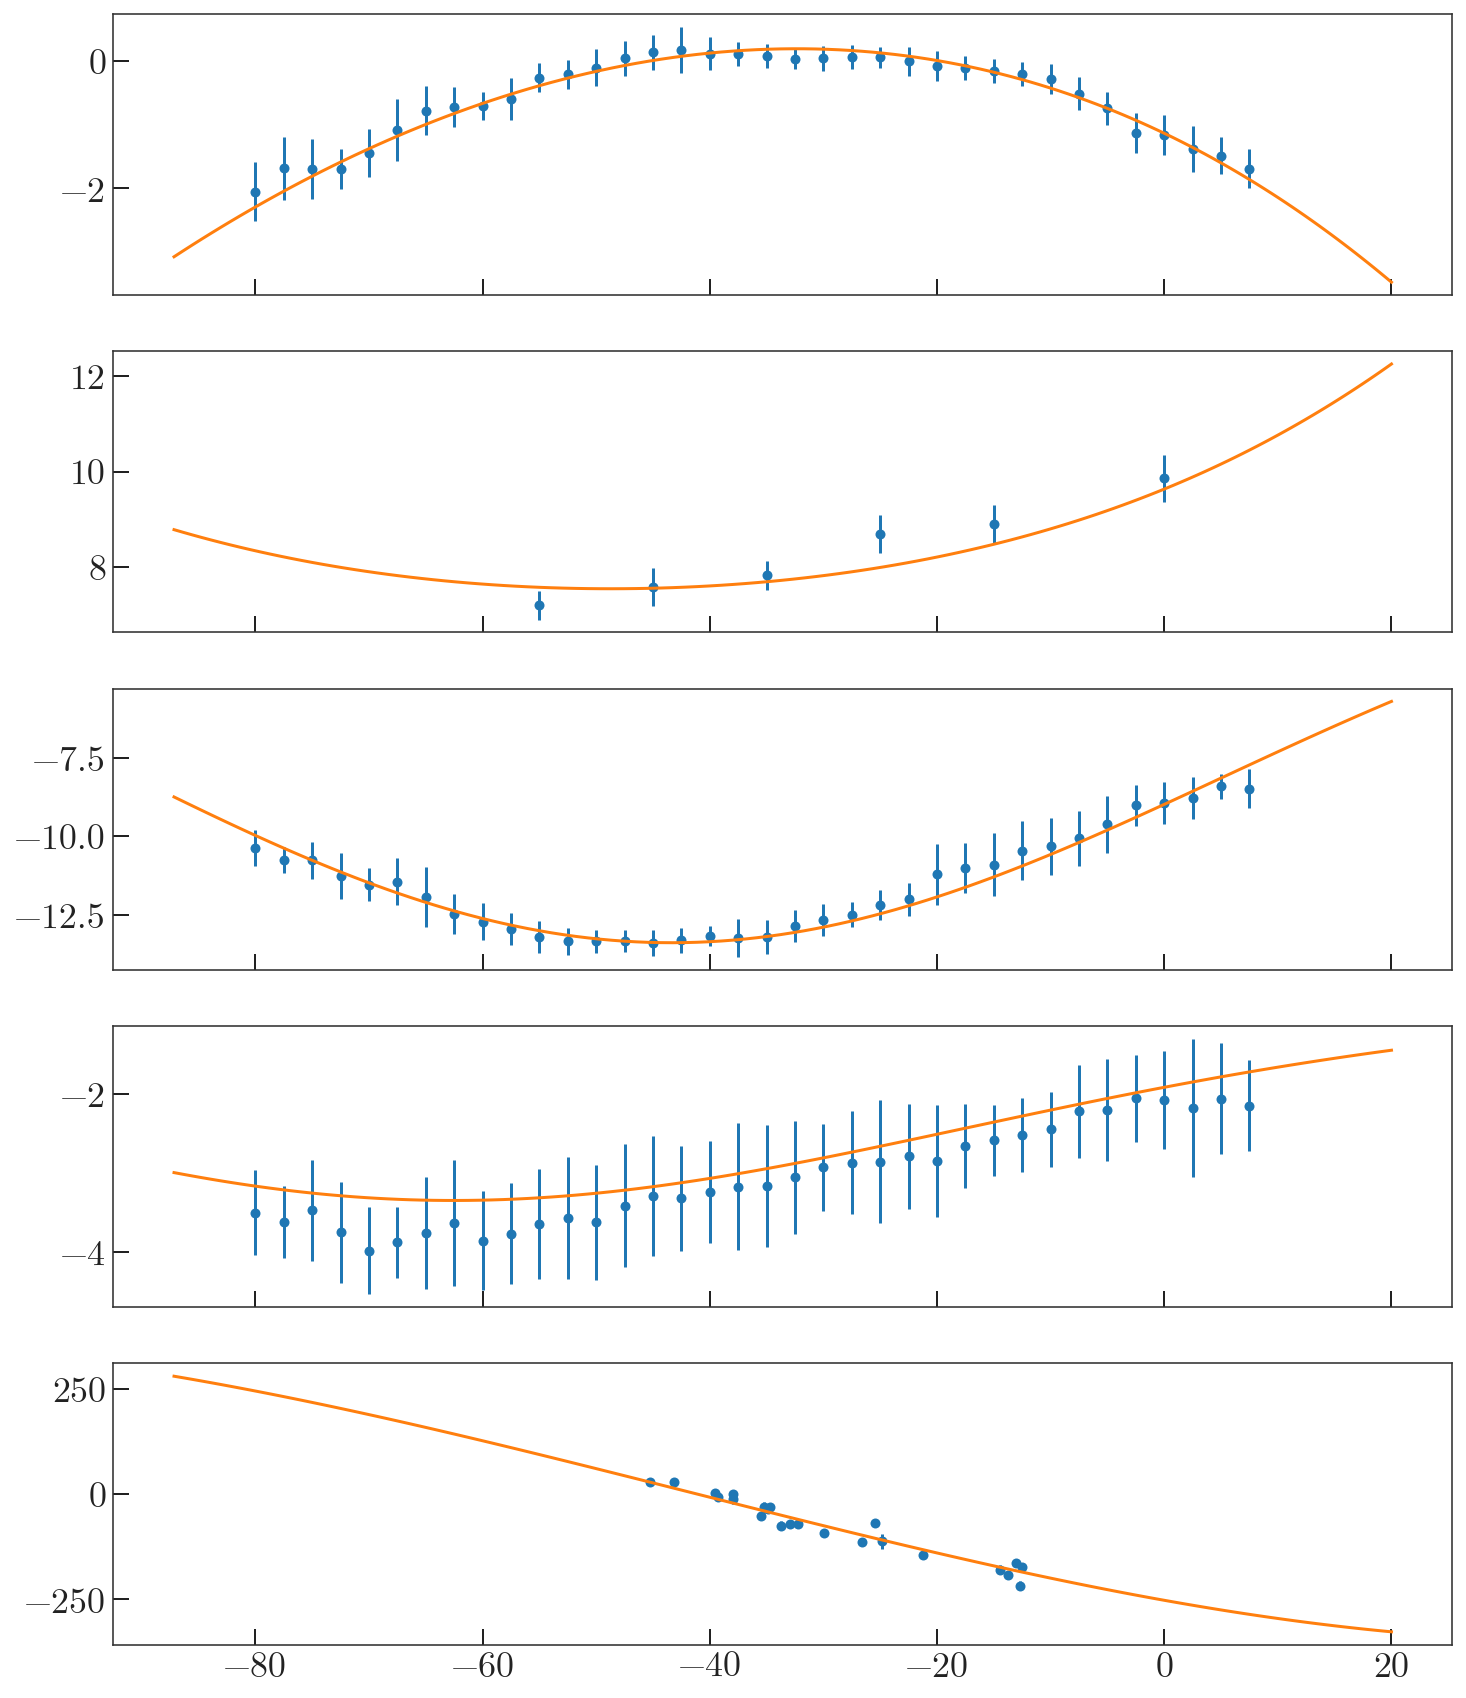

In [11]:
fig, axes = plt.subplots(5, 1, figsize=(12, 15), sharex=True)

axes[0].errorbar(data['phi2'][0], data['phi2'][1], data['phi2'][2], marker='o', linestyle='none')
axes[1].errorbar(data['dist'][0], data['dist'][1], data['dist'][2], marker='o', linestyle='none')
axes[2].errorbar(data['pm1'][0], data['pm1'][1], data['pm1'][2], marker='o', linestyle='none')
axes[3].errorbar(data['pm2'][0], data['pm2'][1], data['pm2'][2], marker='o', linestyle='none')
axes[4].errorbar(data['vr'][0], data['vr'][1], data['vr'][2], marker='o', linestyle='none')

phi2, d, pm1, pm2, vr = res.x
# phi2, d, pm1, pm2, vr = p0

c = gc.GD1(phi1=phi1_0, phi2=phi2*u.deg, distance=d*u.kpc, 
           pm_phi1_cosphi2=pm1*u.mas/u.yr,
           pm_phi2=pm2*u.mas/u.yr,
           radial_velocity=vr*u.km/u.s)
w0 = gd.PhaseSpacePosition(c.transform_to(gc_frame).cartesian)

fit_orbit = ham.integrate_orbit(w0, dt=dt, n_steps=125)
model_gd1 = fit_orbit.to_coord_frame(gc.GD1, galactocentric_frame=gc_frame)

model_x = model_gd1.phi1.wrap_at(180*u.deg).degree

axes[0].plot(model_x, model_gd1.phi2.degree, marker='', zorder=100)
axes[1].plot(model_x, model_gd1.distance, marker='', zorder=100)
axes[2].plot(model_x, model_gd1.pm_phi1_cosphi2.to(u.mas/u.yr).value, marker='', zorder=100)
axes[3].plot(model_x, model_gd1.pm_phi2.to(u.mas/u.yr).value, marker='', zorder=100)
axes[4].plot(model_x, model_gd1.radial_velocity.to(u.km/u.s).value, marker='', zorder=100)

In [17]:
fit_orbit_longer_back = ham.integrate_orbit(w0, dt=-0.5, t1=0*u.Myr, t2=-500*u.Myr)
fit_orbit_longer_forw = ham.integrate_orbit(w0, dt=0.5, t1=0*u.Myr, t2=500*u.Myr)

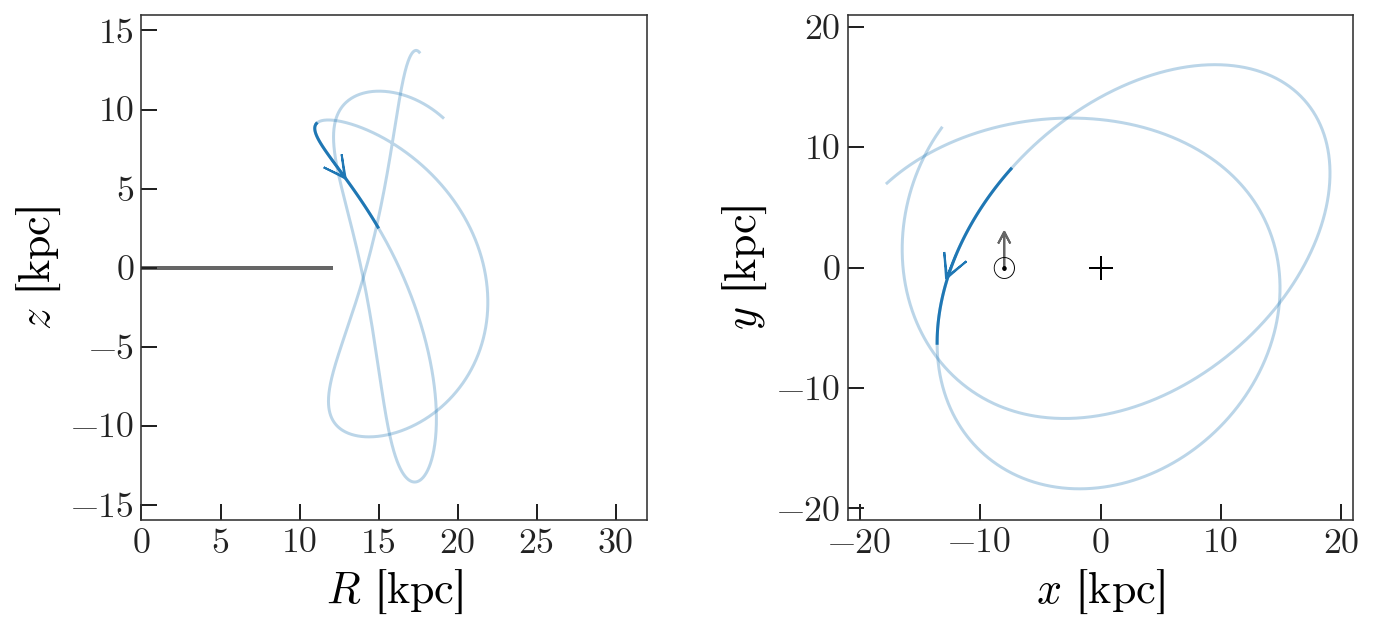

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4.5))

axes[0].plot(fit_orbit.cylindrical.rho.value, 
             fit_orbit.cylindrical.z.value, marker='')

for thing in [fit_orbit_longer_back, fit_orbit_longer_forw]:
    axes[0].plot(thing.cylindrical.rho.value, 
                 thing.cylindrical.z.value, 
                 marker='', alpha=0.3, color='tab:blue', zorder=-100)
    axes[1].plot(thing.x.value, 
                 thing.y.value, 
                 marker='', alpha=0.3, color='tab:blue', zorder=-100)

axes[0].plot([0,12], [0,0], marker='',
             zorder=-10, linewidth=2, color='#666666')

axes[1].plot(fit_orbit.x.value, 
             fit_orbit.y.value, marker='')

i1 = fit_orbit.shape[0]//2

x1 = fit_orbit.cylindrical.rho.value[i1]
x2 = fit_orbit.cylindrical.rho.value[i1+1]
y1 = fit_orbit.z.value[i1]
y2 = fit_orbit.z.value[i1+1]

# positive because we integrate backwards!
axes[0].arrow(x1, y1, (x2-x1), (y2-y1),
              linewidth=1, 
              fc='tab:blue', ec='tab:blue',  
              head_width=1.4, head_length=1.4, zorder=-10, 
              head_starts_at_zero=False, overhang=0.9)


x1 = fit_orbit.x.value[i1]
x2 = fit_orbit.x.value[i1+1]
y1 = fit_orbit.y.value[i1]
y2 = fit_orbit.y.value[i1+1]

# positive because we integrate backwards!
axes[1].arrow(x1, y1, (x2-x1), (y2-y1),
              linewidth=1, 
              fc='tab:blue', ec='tab:blue',  
              head_width=2, head_length=2, zorder=-10, 
              head_starts_at_zero=False, overhang=0.9)

axes[1].scatter(0, 0, marker='+', linewidth=1, s=150, c='k')
axes[1].text(-8.04, 0, r'$\odot$', ha='center', va='center', fontsize=16)
a = axes[1].arrow(-8, 0, 0., 2., linewidth=1, 
                  fc='#666666', ec='#666666', overhang=0.9,
                  head_width=1, head_length=1., zorder=-10)
# --

axes[0].set_xlim(0, 32)
axes[0].xaxis.set_ticks(np.arange(0, 30+1, 5))
axes[0].set_ylim(-16, 16)

axes[1].set_xlim(-21, 21)
axes[1].set_ylim(-21, 21)
axes[1].xaxis.set_ticks(np.arange(-20, 20+1, 10))
axes[1].yaxis.set_ticks(np.arange(-20, 20+1, 10))

axes[0].set_xlabel('$R$ [{0:latex}]'.format(u.kpc))
axes[0].set_ylabel('$z$ [{0:latex}]'.format(u.kpc))
axes[1].set_xlabel('$x$ [{0:latex}]'.format(u.kpc))
axes[1].set_ylabel('$y$ [{0:latex}]'.format(u.kpc))

fig.tight_layout()

axes[0].set_aspect('equal')
axes[1].set_aspect('equal')

fig.savefig('../paper/orbitfit.pdf')

In [14]:
long_orbit = ham.integrate_orbit(w0, dt=0.5, t1=0*u.Myr, t2=6*u.Gyr)
long_orbit.pericenter(), long_orbit.apocenter()

(<Quantity 13.66638572 kpc>, <Quantity 22.17257829 kpc>)

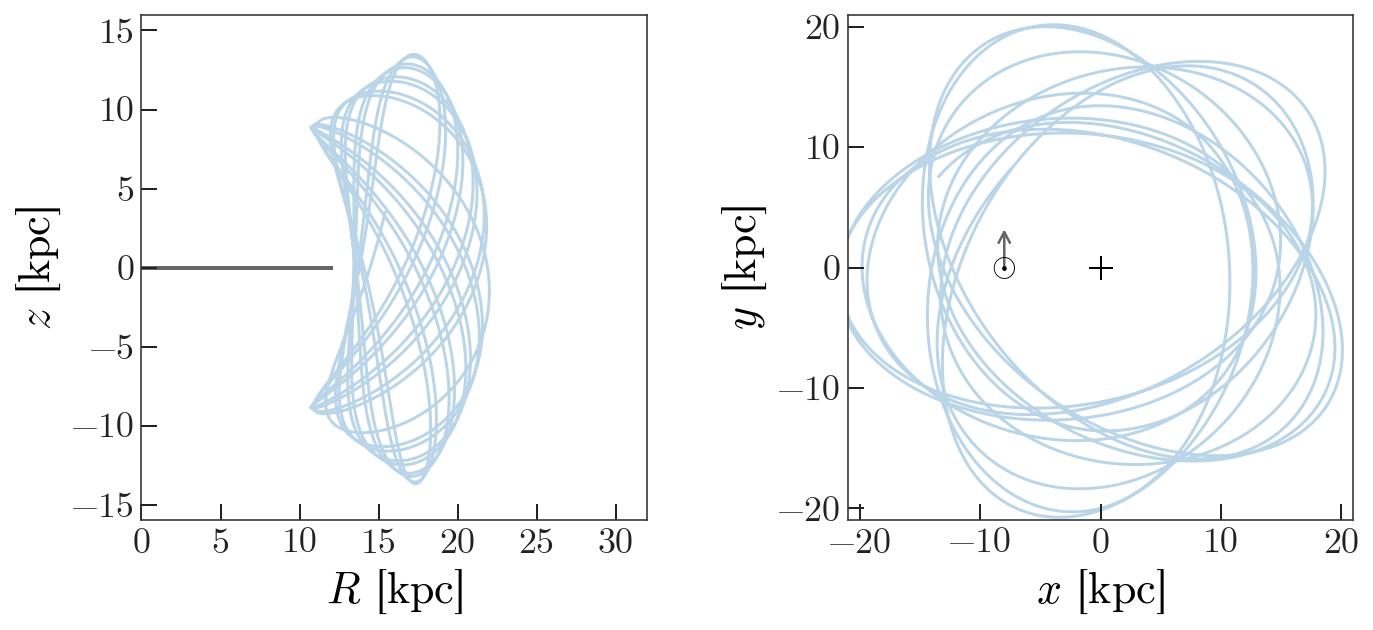

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4.5))

axes[0].plot(long_orbit.cylindrical.rho.value, 
             long_orbit.cylindrical.z.value, 
             marker='', alpha=0.3, color='tab:blue', zorder=-100)
axes[1].plot(long_orbit.x.value, 
             long_orbit.y.value, 
             marker='', alpha=0.3, color='tab:blue', zorder=-100)

axes[0].plot([0,12], [0,0], marker='',
             zorder=-10, linewidth=2, color='#666666')

axes[1].scatter(0, 0, marker='+', linewidth=1, s=150, c='k')
axes[1].text(-8.04, 0, r'$\odot$', ha='center', va='center', fontsize=16)
a = axes[1].arrow(-8, 0, 0., 2., linewidth=1, 
                  fc='#666666', ec='#666666', overhang=0.9,
                  head_width=1, head_length=1., zorder=-10)
# --

axes[0].set_xlim(0, 32)
axes[0].xaxis.set_ticks(np.arange(0, 30+1, 5))
axes[0].set_ylim(-16, 16)

axes[1].set_xlim(-21, 21)
axes[1].set_ylim(-21, 21)
axes[1].xaxis.set_ticks(np.arange(-20, 20+1, 10))
axes[1].yaxis.set_ticks(np.arange(-20, 20+1, 10))

axes[0].set_xlabel('$R$ [{0:latex}]'.format(u.kpc))
axes[0].set_ylabel('$z$ [{0:latex}]'.format(u.kpc))
axes[1].set_xlabel('$x$ [{0:latex}]'.format(u.kpc))
axes[1].set_ylabel('$y$ [{0:latex}]'.format(u.kpc))

fig.tight_layout()

axes[0].set_aspect('equal')
axes[1].set_aspect('equal')

fig.savefig('../plots/orbitfit-long.pdf')

# Mock stream

Now, given a phi1 position for the "progenitor", produce a stream!

In [ ]:
prog_phi0 = -13.5*u.deg
# prog_phi0 = 10*u.deg

model_gd1 = fit_orbit.to_coord_frame(gc.GD1, galactocentric_frame=gc_frame)
prog_i = np.abs(model_gd1.phi1.wrap_at(180*u.deg) - prog_phi0).argmin()
prog_w0 = fit_orbit[prog_i][0]
print(prog_w0)

In [ ]:
prog_orbit = ham.integrate_orbit(prog_w0, 
                                 dt=-0.5, t1=0*u.Myr, t2=-4*u.Gyr)
prog_orbit = prog_orbit[::-1]

In [ ]:
streakline_stream = mockstream.streakline_stream(ham, prog_orbit, 6e4*u.Msun, release_every=1)

In [ ]:
# stream = mockstream.fardal_stream(ham, prog_orbit, 4E5*u.Msun, release_every=1)

# t_disrupt = -200*u.Myr
t_disrupt = 0 *u.Myr
n_times = (prog_orbit.t < t_disrupt).sum()
prog_mass = np.linspace(1E5, 2E3, n_times)
prog_mass = np.concatenate((prog_mass, np.zeros(len(prog_orbit.t) - n_times))) * u.Msun
plt.plot(prog_orbit.t, prog_mass)
stream = mockstream.dissolved_fardal_stream(ham, prog_orbit, prog_mass=prog_mass, 
                                            t_disrupt=t_disrupt, release_every=1)

In [ ]:
_ = stream.plot()

In [ ]:
pos = stream.pos.xyz.to(u.kpc).value.T
vel = stream.vel.d_xyz.to(u.km/u.s).value.T
pos_vel = np.hstack((pos, vel))
np.save('../data/stream_model.npy', pos_vel)

In [ ]:
stream_gd1 = stream.to_coord_frame(gc.GD1, galactocentric_frame=gc_frame)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3), sharex=True, sharey=True)

cs = ax.scatter(stream_gd1.phi1.wrap_at(180*u.deg).degree, 
                stream_gd1.phi2.degree, 
                alpha=0.1, linewidth=0,
                s=10)
ax.set_ylim(-10, 5)
ax.set_xlim(-80, 10)
# fig.colorbar(cs)

ax.set_xlabel(r'$\phi_1$')
ax.set_ylabel(r'$\phi_2$')

fig.savefig('/Users/adrian/Downloads/phi1phi2.png')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3), sharex=True, sharey=True)

cs = ax.scatter(stream_gd1.phi1.wrap_at(180*u.deg).degree, 
                stream_gd1.distance.distmod, 
                alpha=0.1, linewidth=0,
                s=10)
ax.set_xlim(-100, 20)
ax.set_ylim(14, 15.5)
# fig.colorbar(cs)
ax.set_xlabel(r'$\phi_1$')
ax.set_ylabel('dist. mod')

fig.savefig('/Users/adrian/Downloads/distmod.png', dpi=250)

In [ ]:
fig, axes = plt.subplots(5, 1, figsize=(12, 15), sharex=True)

axes[0].errorbar(data['phi2'][0], data['phi2'][1], data['phi2'][2], marker='o', linestyle='none', color='tab:red')
axes[1].errorbar(data['dist'][0], data['dist'][1], data['dist'][2], marker='o', linestyle='none', color='tab:red')
axes[2].errorbar(data['pm1'][0], data['pm1'][1], data['pm1'][2], marker='o', linestyle='none', color='tab:red')
axes[3].errorbar(data['pm2'][0], data['pm2'][1], data['pm2'][2], marker='o', linestyle='none', color='tab:red')
axes[4].errorbar(data['vr'][0], data['vr'][1], data['vr'][2], marker='o', linestyle='none', color='tab:red')

_x = stream_gd1.phi1.wrap_at(180*u.deg).degree
style = dict(alpha=0.1, linewidth=0, s=10, c='k', zorder=-100)
axes[0].scatter(_x, stream_gd1.phi2.degree, **style)
axes[1].scatter(_x, stream_gd1.distance, **style)
axes[2].scatter(_x, stream_gd1.pm_phi1_cosphi2.to(u.mas/u.yr).value, **style)
axes[3].scatter(_x, stream_gd1.pm_phi2.to(u.mas/u.yr).value, **style)
axes[4].scatter(_x, stream_gd1.radial_velocity.to(u.km/u.s).value, **style)

axes[0].set_ylim(-8, 3)
axes[1].set_ylim(5, 13)
axes[2].set_ylim(-16, -5)
axes[3].set_ylim(-6, 0)
axes[4].set_ylim(-300, 300)

axes[0].set_xlim(-80, 10)

fig.tight_layout()

In [ ]:
streak_stream_gd1 = streakline_stream.to_coord_frame(gc.GD1, galactocentric_frame=gc_frame)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3), sharex=True, sharey=True)

cs = ax.scatter(streak_stream_gd1.phi1.wrap_at(180*u.deg).degree, 
                streak_stream_gd1.phi2, 
                alpha=0.06, linewidth=0, s=15)

ax.set_xlim(-85, 10)
ax.set_ylim(-4, 1)

---